In [189]:
from warnings import simplefilter

import numpy as np
import pandas as pd

from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import (
    EnsembleForecaster,
    ReducedForecaster,
    TransformedTargetForecaster,
)
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.performance_metrics.forecasting import sMAPE, smape_loss
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series
from sktime.forecasting.fbprophet import Prophet
from sklearn.model_selection import GridSearchCV
import pickle

simplefilter("ignore", FutureWarning)
%matplotlib inline

In [190]:
sorted_sales=pd.read_csv('sorted_sales.csv')
sorted_sales.head()

,item_id,dept_id,cat_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,...,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941,sales_sum
0,FOODS_3_090,FOODS_3,FOODS,1046,1036,673,642,531,877,1117,...,736,675,374.0,369.0,380.0,400.0,626.0,682,679.0,1017916
1,FOODS_3_586,FOODS_3,FOODS,516,479,328,376,319,430,405,...,499,556,364.0,415.0,375.0,334.0,451.0,498,583.0,932236
2,FOODS_3_252,FOODS_3,FOODS,289,273,157,172,132,218,227,...,430,378,272.0,318.0,330.0,225.0,309.0,345,416.0,573723
3,FOODS_3_555,FOODS_3,FOODS,321,315,214,204,159,265,240,...,256,269,209.0,188.0,215.0,212.0,279.0,295,320.0,497881
4,FOODS_3_587,FOODS_3,FOODS,298,353,234,310,205,214,190,...,233,352,233.0,160.0,190.0,170.0,216.0,240,294.0,402159


In [191]:
sorted_sales = sorted_sales.reset_index()

In [193]:
day=[col for col in sorted_sales.columns if 'd_' in col]
#day

In [194]:
sales_df = sorted_sales.set_index('item_id')[day].T\
    .merge(calendar.set_index('d')['date'],
          left_index=True,
          right_index=True,
          validate='1:1')\
    .set_index('date')
sales_df.index = pd.to_datetime(sales_df.index)

sales_df['total_sales'] = sales_df.sum(axis=1)
sales_df.head()

,FOODS_3_090,FOODS_3_586,FOODS_3_252,FOODS_3_555,FOODS_3_587,FOODS_3_714,FOODS_3_694,FOODS_3_226,FOODS_3_202,FOODS_3_120,...,HOUSEHOLD_2_307,HOUSEHOLD_2_130,HOUSEHOLD_2_245,HOBBIES_2_111,HOBBIES_2_084,HOUSEHOLD_2_005,HOUSEHOLD_2_175,HOBBIES_2_119,HOUSEHOLD_2_101,total_sales
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,1046.0,516.0,289.0,321.0,298.0,238.0,291.0,210.0,106.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32631.0
2011-01-30,1036.0,479.0,273.0,315.0,353.0,215.0,230.0,168.0,113.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31749.0
2011-01-31,673.0,328.0,157.0,214.0,234.0,141.0,187.0,119.0,65.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23783.0
2011-02-01,642.0,376.0,172.0,204.0,310.0,144.0,200.0,165.0,80.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25412.0
2011-02-02,531.0,319.0,132.0,159.0,205.0,96.0,136.0,116.0,75.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19146.0


In [195]:
sales_df.index

DatetimeIndex(['2011-01-29', '2011-01-30', '2011-01-31', '2011-02-01',
               '2011-02-02', '2011-02-03', '2011-02-04', '2011-02-05',
               '2011-02-06', '2011-02-07',
               ...
               '2016-05-13', '2016-05-14', '2016-05-15', '2016-05-16',
               '2016-05-17', '2016-05-18', '2016-05-19', '2016-05-20',
               '2016-05-21', '2016-05-22'],
              dtype='datetime64[ns]', name='date', length=1941, freq=None)

In [196]:
sales_df.to_csv('sales_df.csv')

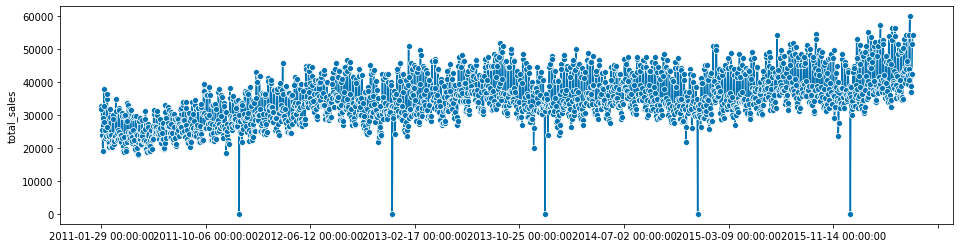

In [197]:
y_df = sales_df[['total_sales']]
y_df.index=sales_df.index
y_df.reset_index()
y=sales_df['total_sales']
plot_series(y);
#print(y_train.shape[0], y_test.shape[0])

In [229]:
y_df

,total_sales
date,
2011-01-29,32631.0
2011-01-30,31749.0
2011-01-31,23783.0
2011-02-01,25412.0
2011-02-02,19146.0
...,...
2016-05-18,37096.0
2016-05-19,36963.0
2016-05-20,42552.0


In [230]:
calendar=pd.read_csv('calendar.csv')

In [232]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [198]:
y_df.to_csv('y_df.csv')
#y_df
pd.read_csv('y_df.csv')

,date,total_sales
0,2011-01-29,32631.0
1,2011-01-30,31749.0
2,2011-01-31,23783.0
3,2011-02-01,25412.0
4,2011-02-02,19146.0
...,...,...
1936,2016-05-18,37096.0
1937,2016-05-19,36963.0
1938,2016-05-20,42552.0
1939,2016-05-21,51518.0


In [199]:
y= y.asfreq('d')

In [200]:
y

date
2011-01-29    32631.0
2011-01-30    31749.0
2011-01-31    23783.0
2011-02-01    25412.0
2011-02-02    19146.0
               ...   
2016-05-18    37096.0
2016-05-19    36963.0
2016-05-20    42552.0
2016-05-21    51518.0
2016-05-22    54338.0
Freq: D, Name: total_sales, Length: 1941, dtype: float64

1913 28


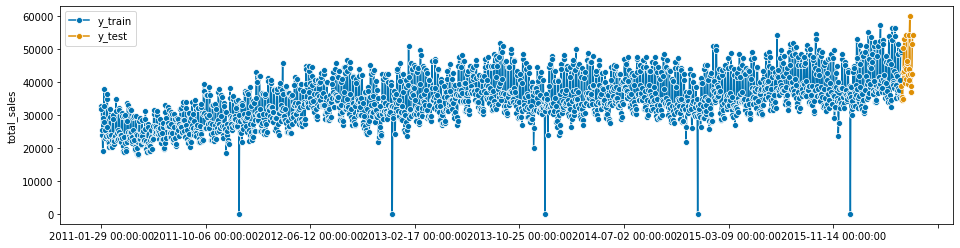

In [201]:
y_train, y_test = temporal_train_test_split(y, test_size=28)
plot_series(y_train, y_test, labels=["y_train", "y_test"])
print(y_train.shape[0], y_test.shape[0])

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='total_sales'>)

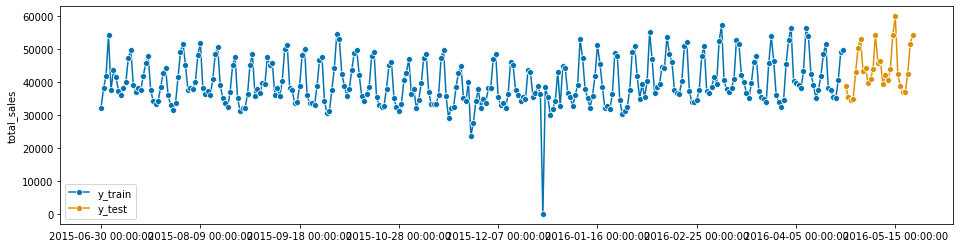

In [202]:
plot_series(y_train[-300:], y_test, labels=["y_train", "y_test"])

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='total_sales'>)

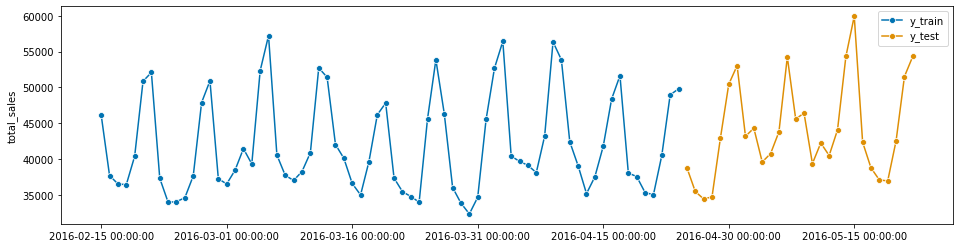

In [203]:
plot_series(y_train[-70:], y_test, labels=["y_train", "y_test"])

In [204]:
fh = np.arange(len(y_test)) + 1
fh

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28])

In [205]:
fh = ForecastingHorizon(y_test.index, is_relative=False)
fh

ForecastingHorizon(['2016-04-25', '2016-04-26', '2016-04-27', '2016-04-28',
               '2016-04-29', '2016-04-30', '2016-05-01', '2016-05-02',
               '2016-05-03', '2016-05-04', '2016-05-05', '2016-05-06',
               '2016-05-07', '2016-05-08', '2016-05-09', '2016-05-10',
               '2016-05-11', '2016-05-12', '2016-05-13', '2016-05-14',
               '2016-05-15', '2016-05-16', '2016-05-17', '2016-05-18',
               '2016-05-19', '2016-05-20', '2016-05-21', '2016-05-22'],
              dtype='datetime64[ns]', name='date', freq='D', is_relative=False)

In [234]:
df_sales

NameError: name 'df_sales' is not defined

In [206]:
# save the model
def save_model(model_name):
    #print(model_name)
    filename = './Models/'+str(model_name)+'.pkl'
    pickle.dump(model_name, open(filename, 'wb'))

In [207]:
result=pd.DataFrame(columns=['model', 'smape_loss'])
result.shape

(0, 2)

In [208]:
def load_model(model_name, y_train, y_test, y_prediction):
    #result['model']=model_name
    filename = './Models/'+str(model_name)+'.pkl'
    loaded_model = pickle.load(open(filename, 'rb'))
    plot_series(y_train[-70:], y_test, y_prediction, labels=["y_train", "y_test", "y_pred_"+str(model_name)])
    result=smape_loss(y_test, y_prediction)
    return result
    #df[df["Year"]==2002]

### Naïve baselines

,model,smape_loss
1,sk_naive,0.173581


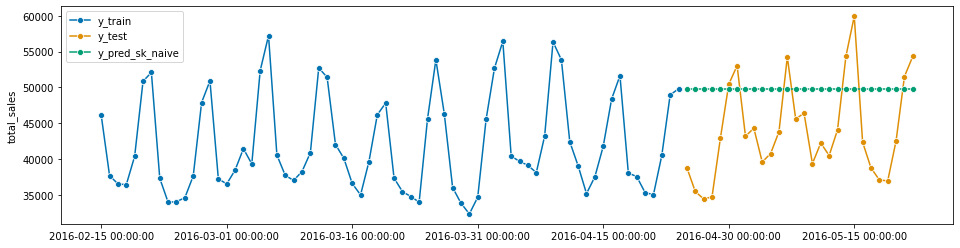

In [209]:

# using sktime
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)
y_pred_naive = forecaster.predict(fh)
save_model('sk_naive')
loss_naive=load_model('sk_naive', y_train, y_test, y_pred_naive)
myindex = result.shape[0]+1 
result.at[myindex,'model']='sk_naive'
result.at[myindex,'smape_loss']=loss_naive
result[result['model']=="sk_naive"]

#### Predicting the last value of the same season

Wall time: 160 ms


,model,smape_loss
2,sk_naive_last_season,0.087535


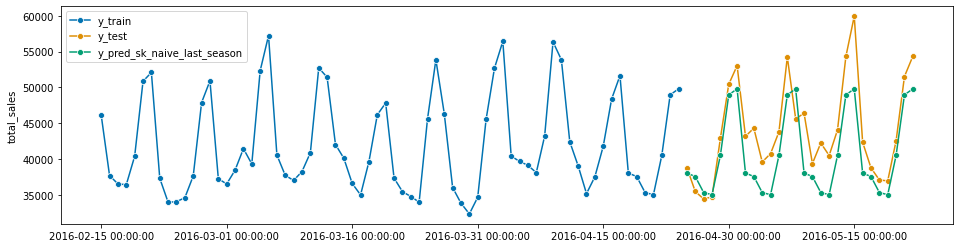

In [210]:
%%time
forecaster = NaiveForecaster(strategy="last", sp=7)
forecaster.fit(y_train)
y_pred_last_season = forecaster.predict(fh)
save_model('sk_naive_last_season')
loss_naive_last_season=load_model('sk_naive_last_season', y_train, y_test, y_pred_last_season)
myindex = result.shape[0]+1 
result.at[myindex,'model']='sk_naive_last_season'
result.at[myindex,'smape_loss']=loss_naive_last_season
result[result['model']=='sk_naive_last_season']

In [211]:
param_grid={
    'sp':np.arange(1, 101),
    'strategy':['last'],
    #'window_length':[1,5,7,10,15,25,50,100]
    
}

In [151]:
%%time


forecaster = NaiveForecaster(window_length=None)

cv = SlidingWindowSplitter(window_length=None, initial_window=int(len(y_train))*0.5)
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=param_grid)

gscv.fit(y_train)
y_pred = gscv.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

ValueError: `window_length` must be a positive integer >= 1 or None, but found: 956.5

Wall time: 597 ms


C:\Users\fast6\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


,model,smape_loss
3,sk_exponential_smoothng,0.08931


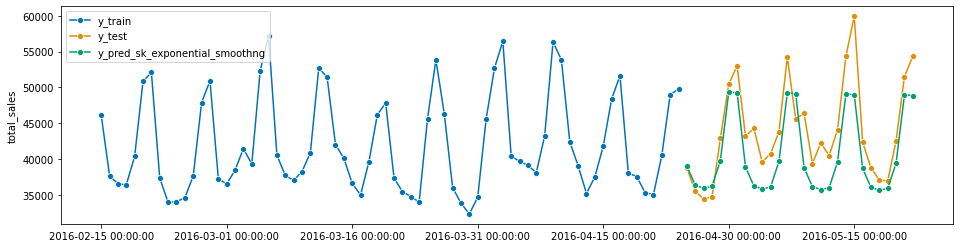

In [212]:
%%time
forecaster = ExponentialSmoothing(trend="add", seasonal="multiplicative", sp=7)
forecaster.fit(y_train)
y_pred_exponential = forecaster.predict(fh)
#plot_series(y_train[-365:], y_test[-365:], y_pred, labels=["y_train", "y_test", "y_pred"])
#smape_loss(y_test, y_pred)
save_model('sk_exponential_smoothng')
loss_exponential_smoothing=load_model('sk_exponential_smoothng', y_train, y_test, y_pred_exponential)
myindex = result.shape[0]+1 
result.at[myindex,'model']='sk_exponential_smoothng'
result.at[myindex,'smape_loss']=loss_exponential_smoothing
result[result['model']=='sk_exponential_smoothng']

Wall time: 1.43 s


,model,smape_loss
4,sk_auto_ets,0.081176


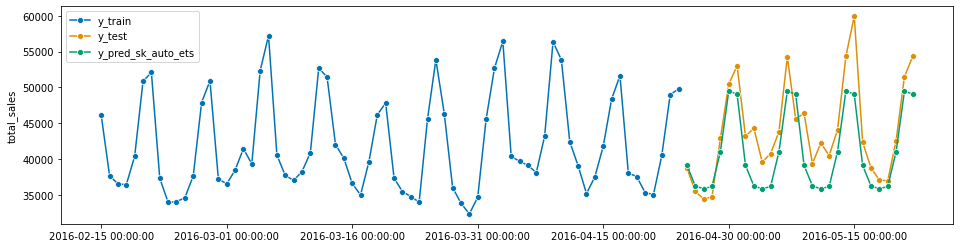

In [213]:
%%time
from sktime.forecasting.ets import AutoETS

forecaster = AutoETS(auto=True, sp=7, n_jobs=-1)
forecaster.fit(y_train)
y_pred_auto_ets = forecaster.predict(fh)
save_model('sk_auto_ets')
loss_auto_ets=load_model('sk_auto_ets', y_train, y_test, y_pred_auto_ets)

myindex = result.shape[0]+1 
result.at[myindex,'model']='sk_auto_ets'
result.at[myindex,'smape_loss']=loss_auto_ets
result[result['model']=='sk_auto_ets']

In [214]:
y_diff= (y-y.shift(1))[1:]
y_diff.head()

date
2011-01-30     -882.0
2011-01-31    -7966.0
2011-02-01     1629.0
2011-02-02    -6266.0
2011-02-03    10065.0
Freq: D, Name: total_sales, dtype: float64

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='total_sales'>)

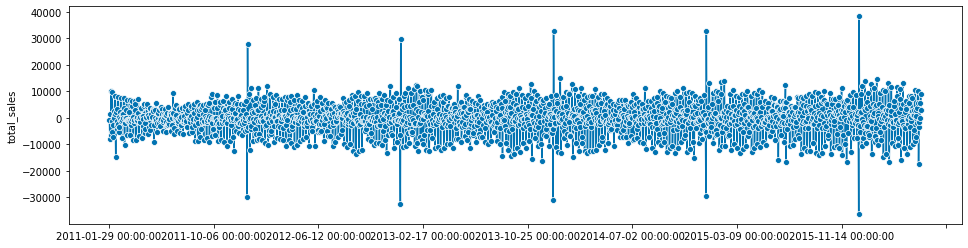

In [215]:
plot_series(y-y.shift(1))

Wall time: 1min 3s


,model,smape_loss
5,sk_autoarima,0.571929


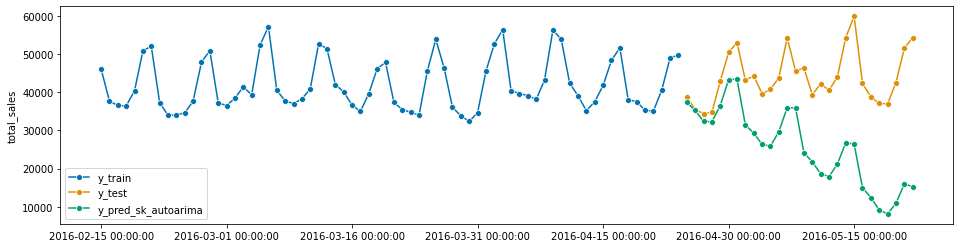

In [216]:
%%time
forecaster = AutoARIMA(sp=7, suppress_warnings=True)
forecaster.fit(y_train)
y_pred_autoarima = forecaster.predict(fh)
save_model('sk_autoarima')
loss_autoarima=load_model('sk_autoarima', y_train, y_test, y_pred_autoarima)

myindex = result.shape[0]+1 
result.at[myindex,'model']='sk_autoarima'
result.at[myindex,'smape_loss']=loss_autoarima
result[result['model']=='sk_autoarima']

In [185]:
#from statsmodels.tsa.stattools import adfuller

#result = adfuller(y_diff)
#print('Test Statistic : ',result[0])
#print('P-value : ',np.round(result[1],decimals=15))

Test Statistic :  -23.638331427812503
P-value :  0.0


In [ ]:
fh

In [186]:
diff_pred= y_train[-1]+np.cumsum(y_pred)
#np.cumsum(y_pred)

NameError: name 'y_pred' is not defined

In [21]:

forecaster = ARIMA(order=(1,0,0),seasonal_order=(0, 0, 0, 365), suppress_warnings=True)
forecaster.fit(y_diff)
y_pred = forecaster.predict(fh)
plot_series(y_train[-30:], y_test[-30:], diff_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, diff_pred)

NameError: name 'y_diff' is not defined

Wall time: 1min 10s


,model,smape_loss
6,sk_bats,0.070344
7,sk_bats,0.070344


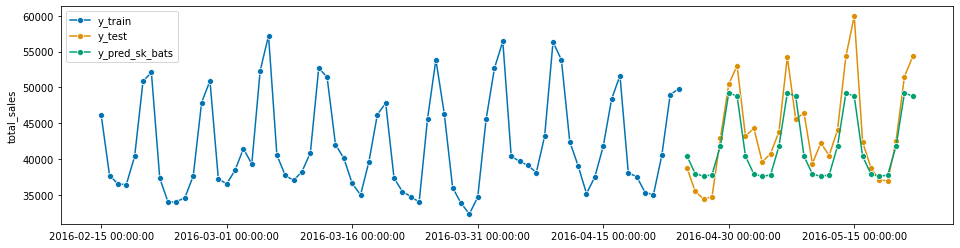

In [218]:
%%time
from sktime.forecasting.bats import BATS

forecaster = BATS(sp=7, use_trend=True, use_box_cox=False)
forecaster.fit(y_train)
y_pred_bats = forecaster.predict(fh)
save_model('sk_bats')
loss_bats= load_model('sk_bats', y_train, y_test, y_pred_bats)

myindex = result.shape[0]+1 
result.at[myindex,'model']='sk_bats'
result.at[myindex,'smape_loss']=loss_bats
result[result['model']=='sk_bats']

In [23]:
y_train

date
2011-01-29    32631.0
2011-01-30    31749.0
2011-01-31    23783.0
2011-02-01    25412.0
2011-02-02    19146.0
               ...   
2016-04-20    35343.0
2016-04-21    35033.0
2016-04-22    40517.0
2016-04-23    48962.0
2016-04-24    49795.0
Freq: D, Name: total_sales, Length: 1913, dtype: float64

Wall time: 4min 4s


,model,smape_loss
8,sk_tbats,0.072434


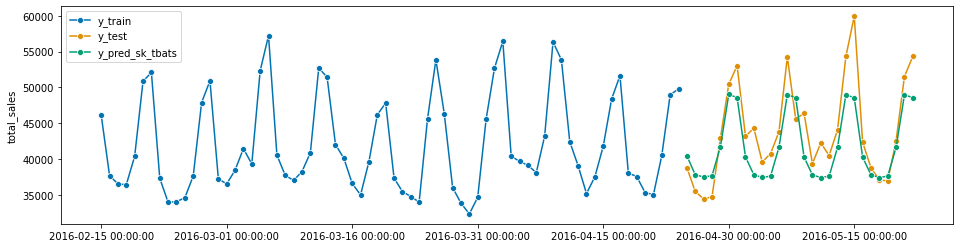

In [219]:
%%time
from sktime.forecasting.tbats import TBATS

forecaster = TBATS(sp=7, use_trend=True, use_box_cox=False)
forecaster.fit(y_train)
y_pred_tbats = forecaster.predict(fh)
save_model('sk_tbats')
loss_tbats=load_model('sk_tbats', y_train, y_test, y_pred_tbats)

myindex = result.shape[0]+1 
result.at[myindex,'model']='sk_tbats'
result.at[myindex,'smape_loss']=loss_tbats
result[result['model']=='sk_tbats']

### skprophet

In [15]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [235]:
sales_df

,FOODS_3_090,FOODS_3_586,FOODS_3_252,FOODS_3_555,FOODS_3_587,FOODS_3_714,FOODS_3_694,FOODS_3_226,FOODS_3_202,FOODS_3_120,...,HOUSEHOLD_2_307,HOUSEHOLD_2_130,HOUSEHOLD_2_245,HOBBIES_2_111,HOBBIES_2_084,HOUSEHOLD_2_005,HOUSEHOLD_2_175,HOBBIES_2_119,HOUSEHOLD_2_101,total_sales
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,1046.0,516.0,289.0,321.0,298.0,238.0,291.0,210.0,106.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32631.0
2011-01-30,1036.0,479.0,273.0,315.0,353.0,215.0,230.0,168.0,113.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31749.0
2011-01-31,673.0,328.0,157.0,214.0,234.0,141.0,187.0,119.0,65.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23783.0
2011-02-01,642.0,376.0,172.0,204.0,310.0,144.0,200.0,165.0,80.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25412.0
2011-02-02,531.0,319.0,132.0,159.0,205.0,96.0,136.0,116.0,75.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19146.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-18,380.0,375.0,330.0,215.0,190.0,219.0,178.0,171.0,126.0,183.0,...,0.0,2.0,1.0,0.0,1.0,0.0,4.0,0.0,1.0,37096.0
2016-05-19,400.0,334.0,225.0,212.0,170.0,156.0,187.0,183.0,137.0,207.0,...,1.0,2.0,0.0,1.0,1.0,3.0,3.0,0.0,1.0,36963.0
2016-05-20,626.0,451.0,309.0,279.0,216.0,228.0,233.0,218.0,170.0,178.0,...,1.0,2.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,42552.0


In [242]:
def format_holidays():
    #dates_s = sales_df.index
    df_ev_1 = pd.DataFrame({'holiday': 'Event 1', 'ds': calendar[~calendar['event_name_1'].isna()]['date']})
    df_ev_2 = pd.DataFrame({'holiday': 'Event 2', 'ds': calendar[~calendar['event_name_2'].isna()]['date']})
    df_ev_3 = pd.DataFrame({'holiday': 'snap_CA', 'ds': calendar[calendar['snap_CA'] == 1]['date']})
    df_ev_4 = pd.DataFrame({'holiday': 'snap_TX', 'ds': calendar[calendar['snap_TX'] == 1]['date']})
    df_ev_5 = pd.DataFrame({'holiday': 'snap_WI', 'ds': calendar[calendar['snap_WI'] == 1]['date']})
    holidays = pd.concat((df_ev_1, df_ev_2, df_ev_3, df_ev_4, df_ev_5))

    holidays['ds'] = pd.to_datetime(holidays['ds'])
    return holidays
holidays = format_holidays()

In [243]:
holidays

,holiday,ds
8,Event 1,2011-02-06
16,Event 1,2011-02-14
23,Event 1,2011-02-21
39,Event 1,2011-03-09
46,Event 1,2011-03-16
...,...,...
1958,snap_WI,2016-06-09
1960,snap_WI,2016-06-11
1961,snap_WI,2016-06-12
1963,snap_WI,2016-06-14


In [19]:
# Convert index to pd.DatetimeIndex
#z = y.copy()

#z = z.to_timestamp(freq="M")
#z_train, z_test = temporal_train_test_split(z, test_size=28)

In [20]:
#z

date
2011-01-29    32631.0
2011-01-30    31749.0
2011-01-31    23783.0
2011-02-01    25412.0
2011-02-02    19146.0
               ...   
2016-05-18    37096.0
2016-05-19    36963.0
2016-05-20    42552.0
2016-05-21    51518.0
2016-05-22    54338.0
Freq: D, Name: total_sales, Length: 1941, dtype: float64

In [221]:
y_train.reset_index()

,date,total_sales
0,2011-01-29,32631.0
1,2011-01-30,31749.0
2,2011-01-31,23783.0
3,2011-02-01,25412.0
4,2011-02-02,19146.0
...,...,...
1908,2016-04-20,35343.0
1909,2016-04-21,35033.0
1910,2016-04-22,40517.0
1911,2016-04-23,48962.0


,model,smape_loss
0,sk_prophet1,0.046495
10,sk_prophet1,0.046495


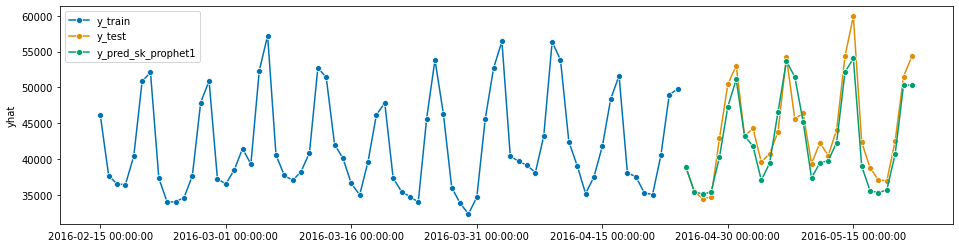

In [244]:
sk_forecaster = Prophet(seasonality_mode='multiplicative', 
                holidays=holidays,
                n_changepoints=2,
                changepoint_range=0.9,
                daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True
                )
sk_forecaster.fit(y_train)
y_pred_prophet1 = sk_forecaster.predict(fh)
y_pred_prophet1.index = y_test.index
save_model('sk_prophet1')
loss_prophet1=load_model('sk_prophet1', y_train, y_test, y_pred_prophet1)

myindex = result.shape[0]+1 
result.at[myindex,'model']='sk_prophet1'
result.at[myindex,'smape_loss']=loss_prophet1
result[result['model']=='sk_prophet1']

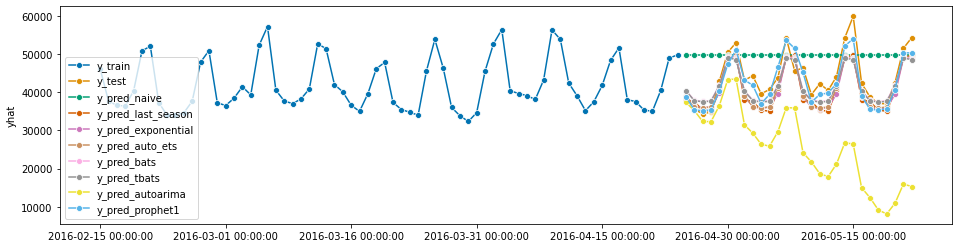

In [223]:
plot_series(y_train[-70:], y_test, y_pred_naive,y_pred_last_season, y_pred_exponential,y_pred_auto_ets,
            y_pred_bats,y_pred_tbats,y_pred_autoarima,y_pred_prophet1,
            labels=["y_train", "y_test", "y_pred_naive","y_pred_last_season", "y_pred_exponential", "y_pred_auto_ets", 
                    "y_pred_bats","y_pred_tbats", "y_pred_autoarima", "y_pred_prophet1"]);

In [154]:
#def highlight_min(s): 
def highlight_max(s): 
    if s.dtype == np.object: 
        is_max = [False for _ in range(s.shape[0])] 
    else: 
        is_max = s == s.max() 
    return ['background: lightgreen' if cell else '' for cell in is_max] 

In [148]:
def highlight_min(data):
    color= 'red'
    attr = 'background-color: {}'.format(color)

    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_min = data == data.min()
        return [attr if v else '' for v in is_min]
    else: 
        is_min = data.groupby(level=0).transform('min') == data
        return pd.DataFrame(np.where(is_min, attr, ''),
                            index=data.index, columns=data.columns)

In [224]:
result=result.sort_values('smape_loss',ignore_index=True)
#result=result.style.apply(highlight_max)
result

,model,smape_loss
0,sk_prophet1,0.046495
1,sk_bats,0.070344
2,sk_bats,0.070344
3,sk_tbats,0.072434
4,sk_auto_ets,0.081176
5,sk_naive_last_season,0.087535
6,sk_exponential_smoothng,0.08931
7,sk_naive,0.173581
8,sk_autoarima,0.571929


In [227]:
pd.bar(result, y="smape_loss", x="model", color="model", title="Smape Losss vs. Model")

AttributeError: module 'pandas' has no attribute 'bar'

In [243]:
#sk_forecaster_gridsearch_prophet
param_grid = {  
    'changepoint_prior_scale':[0.5, 1],
    'seasonality_prior_scale': [1.0, 30],
    'holidays_prior_scale':[1.0, 30],
    'seasonality_mode': ["additive", "multiplicative"],
    #'n_changepoints'=[1,2,3,4,5],
    'changepoint_range': [0.9, 1]    
}


sk_forecaster_gridsearch_prophet = Prophet(
                                holidays=holidays,
                                daily_seasonality=True, weekly_seasonality=True, 
                                yearly_seasonality=True,
                                verbose =1
                                )
sk = GridSearchCV(sk_forecaster_gridsearch_prophet, param_grid=param_grid)




In [46]:
int(len(y_train) * 0.5)

956

In [130]:
%%time
from sklearn.model_selection import ParameterGrid

sk_param_grid = {  
    'changepoint_prior_scale':[10, 30, 50],
    'seasonality_prior_scale': [30, 50, 80],
    'holidays_prior_scale':[30, 80, 100],
    'seasonality_mode': ["additive", "multiplicative"],
    #'n_changepoints'=[1,2,3,4,5],
    'changepoint_range': [0.9, 1]    
    }

# grid = ParameterGrid(sk_param_grid)

# for p in grid:
sk_forecaster_naive_prophet2=Prophet(**p, holidays=holidays,
                                daily_seasonality=True, weekly_seasonality=True, 
                                yearly_seasonality=True,
                                verbose =3)

cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5), fh=28 )#int(len(y_train) * 0.5)
gscv_gridsearch_prophet = ForecastingGridSearchCV(sk_forecaster_naive_prophet2, 
                                                  param_grid= sk_param_grid, cv=cv, verbose=3)

gscv_gridsearch_prophet.fit(z_train)

y_pred = gscv_gridsearch_prophet.predict(fh.to_relative(cutoff=y_train.index[-1]))
y_pred.index = y_test.index
plot_series(y_train[-30:], y_test[-30:], y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

Fitting 1886 folds for each of 108 candidates, totalling 203688 fits


KeyboardInterrupt: 

In [97]:
gscv_gridsearch_prophet.best_params_

<bound method BaseEstimator.get_params of Prophet(changepoint_prior_scale=50.0, changepoint_range=1,
        daily_seasonality=True,
        holidays=      holiday         ds
8     Event 1 2011-02-06
16    Event 1 2011-02-14
23    Event 1 2011-02-21
39    Event 1 2011-03-09
46    Event 1 2011-03-16
...       ...        ...
1958  snap_WI 2016-06-09
1960  snap_WI 2016-06-11
1961  snap_WI 2016-06-12
1963  snap_WI 2016-06-14
1964  snap_WI 2016-06-15

[2117 rows x 2 columns],
        holidays_prior_scale=100.0, seasonality_mode='multiplicative',
        seasonality_prior_scale=80.0, verbose=3, weekly_seasonality=True,
        yearly_seasonality=True)>

In [128]:
%%time
sk_param_grid = {  
    'changepoint_prior_scale':[10, 30, 50],
    'seasonality_prior_scale': [30, 50, 80],
    'holidays_prior_scale':[30, 80, 100],
    'seasonality_mode': ["additive", "multiplicative"],
    #'n_changepoints'=[1,2,3,4,5],
    'changepoint_range': [0.9, 1]   
    }

forecaster_param_grid={}


sk_forecaster_gridsearch_prophet = Prophet(
                                holidays=holidays,
                                daily_seasonality=True, weekly_seasonality=True, 
                                yearly_seasonality=True,
                                verbose =3
                                )

forecaster = GridSearchCV(sk_forecaster_gridsearch_prophet, param_grid=sk_param_grid)

cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5), fh=28 )#int(len(y_train) * 0.5)
gscv_gridsearch_prophet = ForecastingGridSearchCV(forecaster, param_grid= forecaster_param_grid, cv=cv, verbose=3)
#print(gscv)
gscv_gridsearch_prophet.fit(z_train)
y_pred = gscv_gridsearch_prophet.predict(fh.to_relative(cutoff=y_train.index[-1]))
y_pred.index = y_test.index
plot_series(y_train[-30:], y_test[-30:], y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

Fitting 1886 folds for each of 1 candidates, totalling 1886 fits


C:\Users\fast6\anaconda3\lib\site-packages\sktime\forecasting\model_selection\_tune.py:140: FitFailedWarning: forecaster fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found input variables with inconsistent numbers of samples: [956, 1]

  warnings.warn(


ValueError: The forecasting horizon `fh` must be passed either to `fit` or `predict`, but was found in neither.

In [122]:
gscv_gridsearch_prophet.get_params().keys()

dict_keys(['cv', 'error_score', 'forecaster__cv', 'forecaster__error_score', 'forecaster__estimator__add_country_holidays', 'forecaster__estimator__add_seasonality', 'forecaster__estimator__alpha', 'forecaster__estimator__changepoint_prior_scale', 'forecaster__estimator__changepoint_range', 'forecaster__estimator__changepoints', 'forecaster__estimator__daily_seasonality', 'forecaster__estimator__freq', 'forecaster__estimator__growth', 'forecaster__estimator__holidays', 'forecaster__estimator__holidays_prior_scale', 'forecaster__estimator__mcmc_samples', 'forecaster__estimator__n_changepoints', 'forecaster__estimator__seasonality_mode', 'forecaster__estimator__seasonality_prior_scale', 'forecaster__estimator__stan_backend', 'forecaster__estimator__uncertainty_samples', 'forecaster__estimator__verbose', 'forecaster__estimator__weekly_seasonality', 'forecaster__estimator__yearly_seasonality', 'forecaster__estimator', 'forecaster__iid', 'forecaster__n_jobs', 'forecaster__param_grid', 'fore

In [ ]:
#save_model('sk_forecaster_naive_prophet')
#load_model('sk_forecaster_naive_prophet')

sk_forecaster.fit(z_train)
y_pred = sk_forecaster.predict(fh.to_relative(cutoff=y_train.index[-1]))

y_pred.index = y_test.index
plot_series(y_train[-30:], y_test[-30:], y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

In [ ]:
gscv.best_params_

In [ ]:
sk_forecaster = Prophet(seasonality_mode='multiplicative', 
                holidays=holidays,
                n_changepoints=2,
                changepoint_range=0.9,
                daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True
                )
sk_forecaster.fit(z_train)
y_pred = sk_forecaster.predict(fh.to_relative(cutoff=y_train.index[-1]))

y_pred.index = y_test.index
plot_series(y_train[-30:], y_test[-30:], y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

In [63]:
#!pip install xgboost

In [77]:
#!pip install lightgbm

In [26]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [24]:
#from xgboost import XGBRegressor
#xgb = XGBRegressor()
#xgb.fit(z_train, z_test)

In [77]:
%%time
xgb = XGBRegressor()
lgb = LGBMRegressor()
losses = []
grids_boostings = []
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5))
param_grid = {
    "window_length": [x for x in range(4, 30, 2)],
    "regressor": [xgb, lgb]
}

forecaster = ReducedForecaster(regressor=xgb,scitype='regressor')
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=param_grid, scoring=sMAPE(),verbose=1)
gscv.fit(z_train)
results = pd.DataFrame(gscv.cv_results_)
results.head()

Fitting 1913 folds for each of 26 candidates, totalling 49738 fits


KeyboardInterrupt: 

In [74]:
results.sort_values('mean_test_sMAPE')

,mean_fit_time,mean_score_time,param_regressor,param_window_length,params,mean_test_sMAPE,rank_test_sMAPE
25,0.477721,10.869932,LGBMRegressor(),28,"{'regressor': LGBMRegressor(), 'window_length'...",0.064309,1
24,0.374996,10.662077,LGBMRegressor(),26,"{'regressor': LGBMRegressor(), 'window_length'...",0.067766,2
23,0.372005,10.856965,LGBMRegressor(),24,"{'regressor': LGBMRegressor(), 'window_length'...",0.068264,3
22,0.474731,10.676448,LGBMRegressor(),22,"{'regressor': LGBMRegressor(), 'window_length'...",0.068697,4
12,0.778917,10.604640,"XGBRegressor(base_score=None, booster=None, co...",28,"{'regressor': XGBRegressor(base_score=None, bo...",0.070920,5
21,0.349066,10.681435,LGBMRegressor(),20,"{'regressor': LGBMRegressor(), 'window_length'...",0.071064,6
17,0.449797,11.862906,LGBMRegressor(),12,"{'regressor': LGBMRegressor(), 'window_length'...",0.071927,7
18,0.349067,10.698389,LGBMRegressor(),14,"{'regressor': LGBMRegressor(), 'window_length'...",0.072500,8
20,0.349067,10.856414,LGBMRegressor(),18,"{'regressor': LGBMRegressor(), 'window_length'...",0.072538,9
16,0.396938,11.723714,LGBMRegressor(),10,"{'regressor': LGBMRegressor(), 'window_length'...",0.072614,10


In [32]:
gscv.best_params_

{'regressor': LGBMRegressor(), 'window_length': 28}

In [60]:
forecaster = ReducedForecaster(regressor=lgb,scitype='regressor', window_length = 28)
forecaster.fit(z_train)
y_pred = forecaster.predict(fh.to_relative(cutoff=y_train.index[-1]))
y_pred.index = y_test.index

In [183]:
%%time

xgb = XGBRegressor()
lgb = LGBMRegressor()
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5))

xgb_params_grid = {
    #'num_leaves': [10, 25, 50, 100],
    'learning_rate': [0.1, 0.01],
    #'max_depth': [-1, 2, 5, 10],
    'n_estimators': [50, 100, 300]
}
lgb_params_grid = {
    'num_leaves': [10, 25, 50, 100],
    'learning_rate': [0.1, 0.01],
    'max_depth': [-1, 2, 5, 10],
    'n_estimators': [50, 100, 300]
}

gscv_param_grid = {
    "window_length": [20, 68, 100, 360]
    #"regressor": [xgb, lgb]
}

regressor = GridSearchCV(xgb, param_grid=xgb_params_grid,verbose=1)
                         
forecaster = ReducedForecaster(regressor,scitype='regressor')

xgb_gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=gscv_param_grid, scoring=sMAPE(),verbose=1)
xgb_gscv.fit(z_train)
xgb_results = pd.DataFrame(xgb_gscv.cv_results_)
xgb_results

Fitting 1913 folds for each of 4 candidates, totalling 7652 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   15.1s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   34.0s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   46.1s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.6min finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.1min finished


Wall time: 5min 21s


,mean_fit_time,mean_score_time,param_window_length,params,mean_test_sMAPE,rank_test_sMAPE
0,15.911858,12.411127,20,{'window_length': 20},0.073503,3
1,35.572008,12.899970,68,{'window_length': 68},0.064536,1
2,47.966340,12.326559,100,{'window_length': 100},0.064985,2
3,101.924975,12.708987,360,{'window_length': 360},0.075968,4


In [182]:
xgb_gscv.  #best_forecaster_.regressor_.get_xgb_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'monotone_constraints': '()',
 'n_jobs': 4,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [148]:
lgbm31_gscv.best_forecaster_.regressor_.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [156]:
from IPython.display import display_html

In [159]:
def red_reg_results(lgbm_gscv):
    lgbm_output=pd.DataFrame()
    try:
        lgbm_output = pd.concat([lgbm_output, pd.DataFrame(data=lgbm_gscv.best_forecaster_.regressor_.cv_results_)])
    except:
        print('No gridsearch on base estimator')
    try:
        lgbm_output[lgbm_gscv.scoring.name]= lgbm31_gscv.cv_results_['mean_test_'+lgbm_gscv.scoring.name]
        lgbm_output['Rank']= lgbm31_gscv.cv_results_['rank_test_'+lgbm_gscv.scoring.name]
    display_html(lgbm_output.head())
    print(lgbm_gscv.best_score_)
    return lgbm_output

In [160]:
lgbm31=red_reg_results(lgbm31_gscv)

AttributeError: 'LGBMRegressor' object has no attribute 'best_params_'

In [174]:
lgbm31_gscv.cv_results_

{'mean_fit_time': array([0.47885966, 0.61148071, 0.61041284, 0.86191463, 0.84435415,
        1.06956005, 1.42117572]),
 'mean_score_time': array([12.71435475, 11.98947692, 12.06460047, 11.90460896, 11.65959978,
        11.52745438, 12.00778127]),
 'param_window_length': masked_array(data=[10, 30, 60, 90, 120, 180, 360],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'window_length': 10},
  {'window_length': 30},
  {'window_length': 60},
  {'window_length': 90},
  {'window_length': 120},
  {'window_length': 180},
  {'window_length': 360}],
 'mean_test_sMAPE': array([0.07261445, 0.06481797, 0.06348886, 0.06434977, 0.06492573,
        0.06486099, 0.06609317]),
 'rank_test_sMAPE': array([7, 3, 1, 2, 5, 4, 6])}

In [127]:
print(lgbm31_gscv.best_params_, lgbm31_gscv.best_forecaster_.regressor_.best_params_)

{'window_length': 68} {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'num_leaves': 50}


In [176]:
lgbm31_results

In [99]:
print(lgbm2_gscv.best_params_, lgbm2_gscv.best_forecaster_.regressor_.best_params_)

{'window_length': 67} {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'num_leaves': 21}


In [95]:
lgbm2_results = pd.DataFrame(lgbm2_gscv.cv_results_)
lgbm2_results

,mean_fit_time,mean_score_time,param_window_length,params,mean_test_sMAPE,rank_test_sMAPE
0,423.229753,18.061617,65,{'window_length': 65},0.064582,5
1,427.037192,17.079253,66,{'window_length': 66},0.064505,3
2,434.852138,17.689335,67,{'window_length': 67},0.063178,1
3,429.625303,18.595328,68,{'window_length': 68},0.065068,7
4,443.552058,18.756472,69,{'window_length': 69},0.065378,9
5,477.093507,16.265058,70,{'window_length': 70},0.064691,6
6,467.313043,17.405125,71,{'window_length': 71},0.064438,2
7,485.275342,18.398392,72,{'window_length': 72},0.064538,4
8,403.564646,18.826021,73,{'window_length': 73},0.065352,8
9,519.918510,18.636155,74,{'window_length': 74},0.065627,10


In [98]:
print(gscv.best_forecaster_.regressor_.best_params_)

AttributeError: 'LGBMRegressor' object has no attribute 'best_params_'

In [92]:
lgbm_results

,mean_fit_time,mean_score_time,param_window_length,params,mean_test_sMAPE,rank_test_sMAPE
0,307.326448,10.782164,65,{'window_length': 65},0.064582,4
1,304.584704,10.880902,66,{'window_length': 66},0.064785,6
2,292.139406,10.667471,67,{'window_length': 67},0.063635,1
3,295.185229,10.717340,68,{'window_length': 68},0.065068,7
4,296.309453,10.848985,69,{'window_length': 69},0.065378,9
5,438.164654,18.554754,70,{'window_length': 70},0.064691,5
6,650.354492,18.913471,71,{'window_length': 71},0.064438,3
7,567.310256,18.764320,72,{'window_length': 72},0.064391,2
8,564.463476,340.975742,73,{'window_length': 73},0.065352,8
9,520.780686,18.191198,74,{'window_length': 74},0.065627,10


In [108]:
lgbm2_best_params

['learning_rate', 'max_depth', 'n_estimators', 'num_leaves']

In [109]:
lgbm2_best[lgbm2_best_params[0]]

0.1

In [110]:
z_train.head()

date
2011-01-29    32631.0
2011-01-30    31749.0
2011-01-31    23783.0
2011-02-01    25412.0
2011-02-02    19146.0
Freq: D, Name: total_sales, dtype: float64

In [138]:
def red_lgbm():
    lgbm_final = LGBMRegressor(
        #num_leaves=50 #lgbm2_best[lgbm2_best_params[3]],
        #max_depth=lgbm2_best[lgbm2_best_params[1]],
        #learning_rate=lgbm2_best[lgbm2_best_params[0]],
        #n_estimators=lgbm2_best[lgbm2_best_params[2]]
        )
    forecaster = ReducedForecaster(lgbm_final, scitype='regressor',window_length=68)
    forecaster.fit(z_train)
    #forecaster.predict(fh)
    z_pred = forecaster.predict(fh)
    plot_series(z_train[-50:], z_test[-50:], z_pred, labels=["y_train", "y_test", "y_pred"])
    loss= smape_loss(z_test, z_pred)
    print(f"Smape loss: {loss}")
    return loss, forecaster

Smape loss: 0.054883975176836165


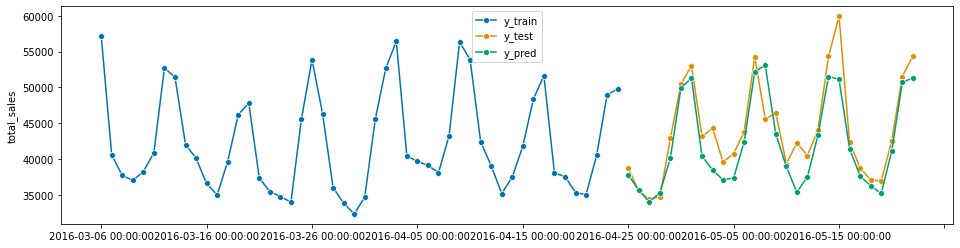

In [139]:
loss, lgbm_default=red_lgbm()

0.05665515545838779

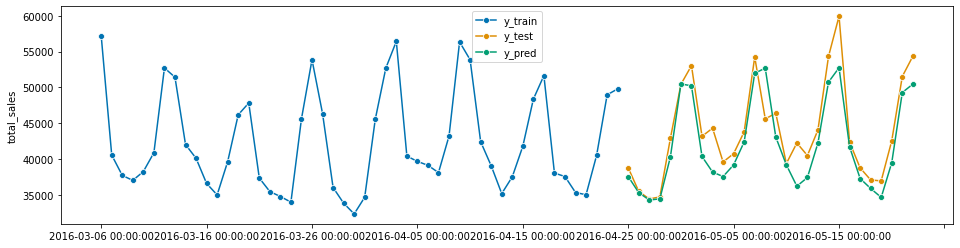

In [129]:
lgbm2_best= lgbm2_gscv.best_forecaster_.regressor_.best_params_
lgbm2_best_params=list(lgbm2_best.keys())
lgbm_final = LGBMRegressor(
    num_leaves=50 #lgbm2_best[lgbm2_best_params[3]],
    #max_depth=lgbm2_best[lgbm2_best_params[1]],
    #learning_rate=lgbm2_best[lgbm2_best_params[0]],
    #n_estimators=lgbm2_best[lgbm2_best_params[2]]
    )
forecaster = ReducedForecaster(lgbm_final, scitype='regressor',window_length=68)
forecaster.fit(z_train)
#forecaster.predict(fh)
z_pred = forecaster.predict(fh)
plot_series(z_train[-50:], z_test[-50:], z_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(z_test, z_pred)


In [128]:
smape_loss(z_test, z_pred)

0.0617180288659719

0.0617180288659719

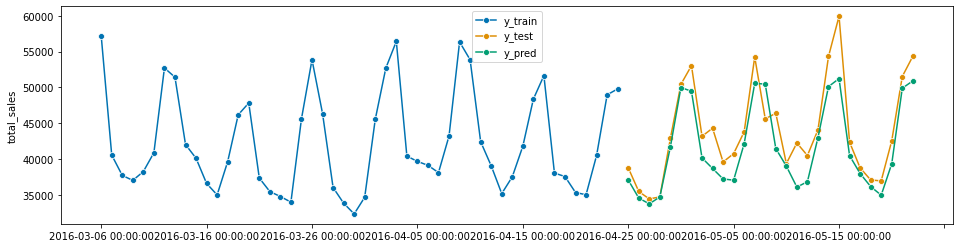

In [96]:
lgbm2_best= lgbm2_gscv.best_forecaster_.regressor_.best_params_

y_pred = lgbm2_gscv.predict(fh)
plot_series(y_train[-50:], y_test[-50:], y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)


In [83]:
lgbm_results

,mean_fit_time,mean_score_time,param_window_length,params,mean_test_sMAPE,rank_test_sMAPE
0,0.942682,14.833572,65,{'window_length': 65},0.063061,3
1,1.248973,15.451163,66,{'window_length': 66},0.063373,5
2,0.958513,15.433148,67,{'window_length': 67},0.063553,8
3,0.910754,14.766489,68,{'window_length': 68},0.063182,4
4,0.776768,14.214342,69,{'window_length': 69},0.063612,9
5,0.781330,13.909317,70,{'window_length': 70},0.062654,1
6,0.925686,13.916313,71,{'window_length': 71},0.063913,10
7,0.793948,14.059824,72,{'window_length': 72},0.062704,2
8,0.803393,13.888250,73,{'window_length': 73},0.063483,7
9,1.037853,13.979857,74,{'window_length': 74},0.063387,6


In [81]:

lgbm_gscv.best_params_, lgbm_gscv.best_score_

({'window_length': 68}, 0.06318216588438558)

0.05408831603295063

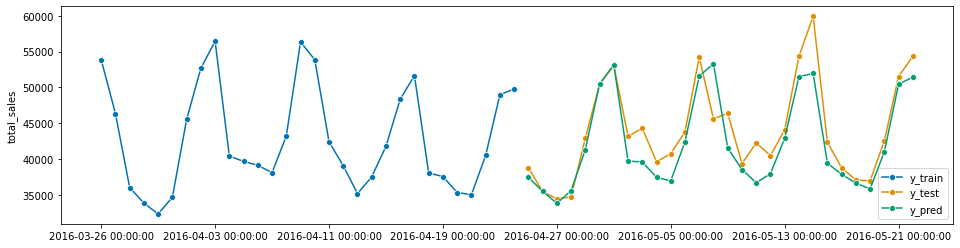

In [61]:
loss = smape_loss(z_test,y_pred)
plot_series(y_train[-30:], y_test[-30:], y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

#losses.append(loss)
#grids_boostings.append(gscv)
#GridSearch results
#output(grids_boostings, losses)

In [ ]:
forecaster = EnsembleForecaster(
    [
        ("ses",  Prophet(seasonality_mode='multiplicative', 
                            holidays=holidays,
                            n_changepoints=2,
                            changepoint_range=0.9,
                            daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True
                            )),
        (
            "holt", Prophet(**p, holidays=holidays,
                                daily_seasonality=True, weekly_seasonality=True, 
                                yearly_seasonality=True,
                                verbose =3),
        ),
#         (
#             "damped",
#             ExponentialSmoothing(
#                 trend="add", damped_trend=True, seasonal="multiplicative", sp=12
#             ),
#         ),
    ]
)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)